In [ ]:
%%capture
!rm -rf /tools/node/*
!wget -c https://nodejs.org/dist/v10.20.1/node-v10.20.1-linux-x64.tar.xz
!sudo tar --overwrite -xJvf node-v10.20.1-linux-x64.tar.xz
!cp -r node-v10.20.1-linux-x64/* /tools/node/ && rm -rf node-v10*
!pip install tensorflowjs

# Getting started with DCP

In this notebook, we'll train and publish a CIFAR10 classifier to the Distributed Computer. This will allow us to submit a large number of tasks to a distributed computer to perform inference on a large number of images in parallel. 

Let's begin in python. 

In [ ]:
%%capture
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflowjs as tfjs

170500096/170498071 [==============================] - 2s 0us/step


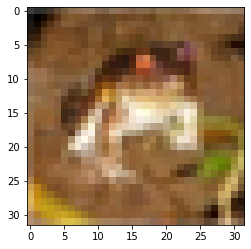

0.0 1.0 float32 (50000, 32, 32, 3) (10000, 1)


In [ ]:
(_xtrain, _ytrain), (_xtest, _ytest) = tf.keras.datasets.cifar10.load_data()
_xtrain = _xtrain.astype(np.float32) / 255.
_xtest  = _xtest.astype(np.float32)  / 255.

_ytrain_onehot = tf.keras.utils.to_categorical(_ytrain, 10)
_ytest_onehot  = tf.keras.utils.to_categorical(_ytest,  10)

plt.imshow(_xtrain[0,...])
plt.show()

print(_xtrain.min(), _xtrain.max(), _xtrain.dtype, _xtrain.shape, _ytest.shape)

In [ ]:

class Classifier(tf.keras.Model):
    def __init__(self, num_classes, name=None):
        super(Classifier, self).__init__(name=name)
        self.num_classes = num_classes
        
        self.ls = [
            tf.keras.layers.Conv2D(32 ,3,strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64 ,3,strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(128,3,strides=2, padding='same', activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(self.num_classes, activation='softmax') # [ 0.1 , 0.2 , 0.3, 0.3, ....]
        ]
    
    @tf.function
    def call(self,x):
        for l in self.ls:
            x = l(x)
        return x

In [ ]:
model = Classifier(10)

model.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
_history = model.fit(_xtrain, _ytrain_onehot,
         batch_size=512,
         verbose=1,
         epochs=20,
         callbacks=[
             tf.keras.callbacks.EarlyStopping(patience=3)
         ],
         validation_data=(_xtest, _ytest_onehot)
)

Epoch 1/20
98/98 [==============================] - 9s 18ms/step - loss: 2.1945 - accuracy: 0.1704 - val_loss: 2.2649 - val_accuracy: 0.1720
Epoch 2/20
98/98 [==============================] - 1s 12ms/step - loss: 2.0094 - accuracy: 0.2614 - val_loss: 1.9411 - val_accuracy: 0.2865
Epoch 3/20
98/98 [==============================] - 1s 12ms/step - loss: 1.8954 - accuracy: 0.3032 - val_loss: 1.7944 - val_accuracy: 0.3437
Epoch 4/20
98/98 [==============================] - 1s 11ms/step - loss: 1.8115 - accuracy: 0.3389 - val_loss: 1.7154 - val_accuracy: 0.3730
Epoch 5/20
98/98 [==============================] - 1s 11ms/step - loss: 1.7485 - accuracy: 0.3614 - val_loss: 1.6335 - val_accuracy: 0.4082
Epoch 6/20
98/98 [==============================] - 1s 11ms/step - loss: 1.6953 - accuracy: 0.3815 - val_loss: 1.6034 - val_accuracy: 0.4087
Epoch 7/20
98/98 [==============================] - 1s 11ms/step - loss: 1.6418 - accuracy: 0.3998 - val_loss: 1.7136 - val_accuracy: 0.3765
Epoch 8/20
98

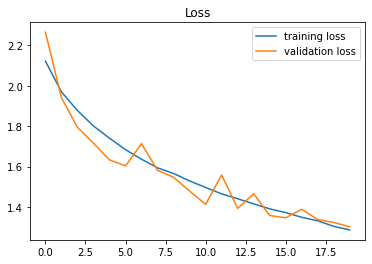

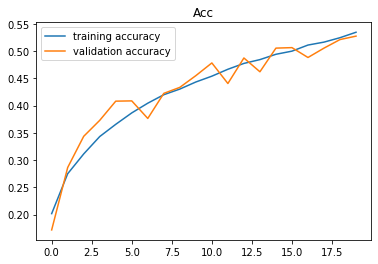

In [ ]:
plt.title("Loss")
plt.plot(_history.history['loss'])
plt.plot(_history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.title("Acc")
plt.plot(_history.history['accuracy'])
plt.plot(_history.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.show() 

# Publishing our model

Now we'll clone this helpful tensorflowjs utility and use tensorflowjs converter to convert our python model to a tensorflowjs model and then publishing this model to the Distributed Computer. 

Make sure the keys you upload are named `id.keystore` and `default.keystore`


In [ ]:
from google.colab import files

_uploaded = files.upload()
print(_uploaded.keys())
!mkdir -p ~/.dcp && mv /content/*.keystore ~/.dcp/

Saving default.keystore to default.keystore
Saving id.keystore to id.keystore
dict_keys(['default.keystore', 'id.keystore'])


In [ ]:
%%capture
!git clone https://github.com/Kings-Distributed-Systems/tfjs_util.git
!cd tfjs_util && npm i && npm run postinstall 

## Publishing

Now to publish the model, we'll save the model as a tensorflowjs model (using tfjs.converters) as well as we will use the tfjs_utils to publish the model under the name `dcp_cifar_10_ex/cifar10.js` with version number `0.1.4`. Note that if you are trying to publish, you won't be able to publish at this location (since I have ownership of this module). If you'd like to publish, change the name and reset the version number. 

If you change the name,  you'll want to change the `job.requires('....');` below in the node segments.

In [ ]:
!mkdir -p './tfjs_model'
!mkdir -p './saved_model'
model.save('./saved_model')
tfjs.converters.convert_tf_saved_model('./saved_model', './tfjs_model')
#Serialize and submit model to DCP package manager with version number X.X.X 
#!node ./tfjs_util/bin/serializeModel.js -m ./tfjs_model/model.json \
#    -o kds_cifar_10/cifar10.js -p 0.1.9 -d

Writing weight file ./tfjs_model/model.json...


# Bifrost

Now we'll use a library that will enable us to run javascript in a jupyter notebook so that we can use the Distributed Compute Protocol to submit inference jobs to the cloud.

In [ ]:
%%capture
!pip install git+https://github.com/Kings-Distributed-Systems/Bifrost.git

In [ ]:
from bifrost import npm, node

#installing the node dcp-client npm i dcp-client
npm.install( 'dcp-client' ) # npm.install( 'dcp-client', '@tensorflow/tfjs' )

Wrote to /content/package.json:

{
"name": "content",
"version": "1.0.0",
"description": "",
"main": "index.js",
"scripts": {
"test": "echo \"Error: no test specified\" && exit 1"
},
"keywords": [],
"author": "",
"license": "ISC"
}



> mmap.js@1.0.3 install /content/node_modules/mmap.js
> node-gyp rebuild

make: Entering directory '/content/node_modules/mmap.js/build'
CXX(target) Release/obj.target/mmap/src/mmap.o
SOLINK_MODULE(target) Release/obj.target/mmap.node
COPY Release/mmap.node
make: Leaving directory '/content/node_modules/mmap.js/build'

> nodeshm@0.1.1 install /content/node_modules/nodeshm
> node-gyp rebuild

make: Entering directory '/content/node_modules/nodeshm/build'
CXX(target) Release/obj.target/shm/shm.o
SOLINK_MODULE(target) Release/obj.target/shm.node
COPY Release/shm.node
make: Leaving directory '/content/node_modules/nodeshm/build'

> xxhash@0.3.0 install /content/node_modules/xxhash
> node-gyp rebuild

make: Entering directory '/content/node_modules/xxhash/buil

In [ ]:
#We're gonna use the demo scheduler
SCHEDULER  = 'https://demo-scheduler.distributed.computer'


In [ ]:
%%node

require('dcp-client').initSync(`${SCHEDULER}`);
const compute = require('dcp/compute');
const wallet = require('dcp/wallet');
const dcpCli = require('dcp/dcp-cli');

var accountKeystore;
var identityKeystore;

(async function(){
    identityKeystore = await dcpCli.getIdentityKeystore();
    wallet.addId(identityKeystore);
    accountKeystore = await dcpCli.getAccountKeystore();
    console.log("Keystores loaded!");
})();

Keystores loaded!


In [ ]:
sample_cifar = _xtest[:100]
cifar_true   = _ytest_onehot[:100]

print("First element in python: ", sample_cifar[0,0,0,0])
sample_cifar.shape, sample_cifar[0,0,0,0], cifar_true.shape, cifar_true.dtype

First element in python:  0.61960787


((100, 32, 32, 3), 0.61960787, (100, 10), dtype('float32'))

In [ ]:
%%node
console.log(sample_cifar.shape, sample_cifar.typedArray[0]);

[ 100, 32, 32, 3 ] 0.6196078658103943


In [ ]:
%%node
var cifarResults = []
async function main(){
    let x = Float32Array.from(sample_cifar.typedArray);
    let y = Float32Array.from(cifar_true.typedArray);
    
    console.log("First element in js: ", x[0]);
    
    let submission_array = [];
    let num_elem_x = sample_cifar.shape[1]*sample_cifar.shape[2]*sample_cifar.shape[3];
    let num_elem_y = cifar_true.shape[1];
    for (let i = 0; i < sample_cifar.shape[0]; i++){
        submission_array.push(
            {
            'x': Array.from(x.slice(i*num_elem_x, (i+1) * num_elem_x)),
            'y': Array.from(y.slice(i*num_elem_y, (i+1) * num_elem_y))   
            }
        );
    }
    
    let job = compute.for( submission_array, async function(data){
        
        progress(0.);
        const tf = require('tfjs');
        tf.setBackend('cpu');
        await tf.ready();
        progress(0.15);
        const model = await require('cifar10').getModel();
        progress(0.45);
        let inpTensor = tf.tensor(data.x, [1, 32, 32, 3], dtype='float32');
        let y_true    = tf.tensor(data.y, [1, 10], dtype='int32');
        progress(0.5);
        let y_pred = model.predict(inpTensor);
        progress(0.75);
        const accuracyTensor = tf.metrics.categoricalAccuracy(y_true, y_pred);
        progress(0.85);
        const acc = accuracyTensor.dataSync()[0];
        progress(1.);
        return acc;
    });
    
    
    job.on('accepted', ()=>{
        console.log("Job Accepted...");
    });
    
    job.on('status', (status)=>{
        console.log("Received a status update: ", status);
    });

    job.on('result', (value)=>{
        cifarResults.push(value.result);
    })

    job.on('console', (output)=>{
        console.log(output.message);
    })
    
    job.on('error', (err)=>{
        console.log(err);
    })
    
    job.requires('aistensorflow/tfjs');
    job.requires('kds_cifar_10_ex/cifar10')
    
//    job.requirements.environment.offscreenCanvas = true;
    job.public.name = 'dcp-workshop';
    
    await job.exec(compute.marketValue, accountKeystore);
    
    console.log("Done Executing job!");
}

main();

First element in js:  0.6196078658103943
Job Accepted...
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 0, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 1, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 2, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 3, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 4, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 5, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 6, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 7, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 8, computed: 0 }
Received a status update:  { runStatus: 'SLOWWORK', total: 100, distributed: 9, computed: 0 }
Rec

In [ ]:
print("Accuracy on distributed 100 set sample: ", sum(cifarResults)/len(cifarResults))

Accuracy on distributed 100 set sample:  0.6


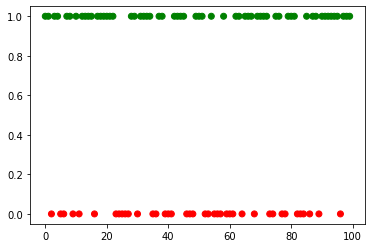

In [ ]:
plt.scatter(range(len(cifarResults)), cifarResults, c = ['green' if i==1 else 'red' for i in cifarResults])
plt.show()

# Docs and First Dev

For more info on the API and getting started, we recommend checking out the dcp docs.

https://docs.dcp.dev/getting-started